In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if "../src" not in sys.path:
    sys.path.append("../src")
    
import json
import pandas as pd
from pathlib import Path
from itertools import chain
from typing import cast, Dict
from tqdm.auto import tqdm
import numpy as np
from praatio import textgrid
from weave import Utterance, Speech, BuildUtt

In [3]:
### Read charac-boundary dictionary
word_syll_map = pd.read_csv(Path("../data/mandarin_taiwan_mfa_redelvar.syll.tsv"), sep="\t")\
                  .groupby("ipa").first().drop("word", axis=1)\
                  .to_dict(orient="index")
word_syll_map = cast(Dict[str, Dict[str, str]], word_syll_map)

In [4]:
speaker_dir = Path("../data/aligned_xianzai/s1")

for tg_path_x in tqdm(sorted(speaker_dir.glob("*.TextGrid"))):
  mfa_json_path = tg_path_x.with_suffix(".mfa.json")
  fa = textgrid.openTextgrid(str(tg_path_x), False)
  fa_words = fa.getTier("words")
  fa_phones = fa.getTier("phones")
  mfa_wlist = BuildUtt.build_words_phones(fa_words, fa_phones)  #type: ignore
  mfa_words = BuildUtt.build_characters(mfa_wlist, word_syll_map)  #type: ignore
  mfa_utt = Utterance.from_words(mfa_words)
  mfa_utt.utt_id = tg_path_x.stem
  speech_x = Speech.from_utterances([mfa_utt])
  mfa_json_path.write_text(json.dumps(speech_x.to_dict()))

  0%|          | 0/852 [00:00<?, ?it/s]

In [5]:
from weave import MfaAgent
CORPUS_NAME = "xianzai"
mfa_dir = Path(f"~/Documents/MFA/{CORPUS_NAME}").expanduser()
agent = MfaAgent(str(mfa_dir), CORPUS_NAME, 
                 speech_json_dir="../data/aligned_xianzai/mfa_json")

STDERR: gmm-copy --binary=false /home/sean/Documents/MFA/xianzai/alignment/final.mdl - 
LOG (gmm-copy[5.5.1068]:main():gmmbin/gmm-copy.cc:75) Written model to -



  0%|          | 0/852 [00:00<?, ?it/s]

LJH_GY_1479 <Word: [0.00-0.12] 現在>
 <Character: [0.00-0.09] 現>
  <Phone: [0.00-0.06] ɕ>
  <Phone: [0.06-0.07] j>
  <Phone: [0.07-0.08] e˥˩>
  <Phone: [0.08-0.09] n>
 <Character: [0.09-0.12] 在>
  <Phone: [0.09-0.12] aj˥˩>


transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 10 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 
LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 32 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.06] ɕ>
<Phone: [0.06-0.07] j>
<Phone: [0.07-0.08] e˥˩>
<Phone: [0.08-0.09] n>
<Phone: [0.09-0.12] aj˥˩>
GYX_GY_6525 <Word: [0.00-0.22] 現在>
 <Character: [0.00-0.19] 現>
  <Phone: [0.00-0.05] ɕ>
  <Phone: [0.05-0.06] j>
  <Phone: [0.06-0.16] e˥˩>
  <Phone: [0.16-0.19] n>
 <Character: [0.19-0.22] 在>
  <Phone: [0.19-0.22] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 27 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.05] ɕ>
<Phone: [0.05-0.06] j>
<Phone: [0.06-0.16] e˥˩>
<Phone: [0.16-0.19] n>
<Phone: [0.19-0.22] aj˥˩>
LXQ_GY_2290 <Word: [0.00-0.29] 現在>
 <Character: [0.00-0.13] 現>
  <Phone: [0.00-0.03] ɕ>
  <Phone: [0.03-0.04] j>
  <Phone: [0.04-0.09] e˥˩>
  <Phone: [0.09-0.13] n>
 <Character: [0.13-0.29] 在>
  <Phone: [0.13-0.17] ts>
  <Phone: [0.17-0.29] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 23 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.03] ɕ>
<Phone: [0.03-0.04] j>
<Phone: [0.04-0.09] e˥˩>
<Phone: [0.09-0.13] n>
<Phone: [0.13-0.17] ts>
<Phone: [0.17-0.29] aj˥˩>
CJJ_GY_1985 <Word: [0.00-0.20] 現在>
 <Character: [0.00-0.16] 現>
  <Phone: [0.00-0.09] ɕ>
  <Phone: [0.09-0.10] j>
  <Phone: [0.10-0.13] e˥˩>
  <Phone: [0.13-0.16] n>
 <Character: [0.16-0.20] 在>
  <Phone: [0.16-0.20] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 25 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.


<Phone: [0.00-0.09] ɕ>
<Phone: [0.09-0.10] j>
<Phone: [0.10-0.13] e˥˩>
<Phone: [0.13-0.16] n>
<Phone: [0.16-0.20] aj˥˩>
QYP_GY_1985 <Word: [0.00-0.22] 現在>
 <Character: [0.00-0.15] 現>
  <Phone: [0.00-0.06] ɕ>
  <Phone: [0.06-0.07] j>
  <Phone: [0.07-0.12] e˥˩>
  <Phone: [0.12-0.15] n>
 <Character: [0.15-0.22] 在>
  <Phone: [0.15-0.18] ts>
  <Phone: [0.18-0.22] aj˥˩>


gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 
LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 36 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.06] ɕ>
<Phone: [0.06-0.07] j>
<Phone: [0.07-0.12] e˥˩>
<Phone: [0.12-0.15] n>
<Phone: [0.15-0.18] ts>
<Phone: [0.18-0.22] aj˥˩>
CYF_GY_5102 <Word: [0.00-0.33] 現在>
 <Character: [0.00-0.22] 現>
  <Phone: [0.00-0.10] ɕ>
  <Phone: [0.10-0.11] j>
  <Phone: [0.11-0.14] e˥˩>
  <Phone: [0.14-0.22] n>
 <Character: [0.22-0.33] 在>
  <Phone: [0.22-0.25] ʈʂ>
  <Phone: [0.25-0.33] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 28 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.10] ɕ>
<Phone: [0.10-0.11] j>
<Phone: [0.11-0.14] e˥˩>
<Phone: [0.14-0.22] n>
<Phone: [0.22-0.25] ʈʂ>
<Phone: [0.25-0.33] aj˥˩>
LCX_GY_0692 <Word: [0.00-0.30] 現在>
 <Character: [0.00-0.16] 現>
  <Phone: [0.00-0.06] ɕ>
  <Phone: [0.06-0.07] j>
  <Phone: [0.07-0.11] e˥˩>
  <Phone: [0.11-0.16] n>
 <Character: [0.16-0.30] 在>
  <Phone: [0.16-0.21] ts>
  <Phone: [0.21-0.30] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 35 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.06] ɕ>
<Phone: [0.06-0.07] j>
<Phone: [0.07-0.11] e˥˩>
<Phone: [0.11-0.16] n>
<Phone: [0.16-0.21] ts>
<Phone: [0.21-0.30] aj˥˩>
HSY_GY_4488 <Word: [0.00-0.37] 現在>
 <Character: [0.00-0.21] 現>
  <Phone: [0.00-0.10] ɕ>
  <Phone: [0.10-0.11] j>
  <Phone: [0.11-0.15] e˥˩>
  <Phone: [0.15-0.21] n>
 <Character: [0.21-0.37] 在>
  <Phone: [0.21-0.25] ts>
  <Phone: [0.25-0.37] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 41 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.10] ɕ>
<Phone: [0.10-0.11] j>
<Phone: [0.11-0.15] e˥˩>
<Phone: [0.15-0.21] n>
<Phone: [0.21-0.25] ts>
<Phone: [0.25-0.37] aj˥˩>
HSY_GY_2207 <Word: [0.00-0.38] 現在>
 <Character: [0.00-0.23] 現>
  <Phone: [0.00-0.10] ɕ>
  <Phone: [0.10-0.11] j>
  <Phone: [0.11-0.17] e˥˩>
  <Phone: [0.17-0.23] n>
 <Character: [0.23-0.38] 在>
  <Phone: [0.23-0.29] ts>
  <Phone: [0.29-0.38] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 49 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.10] ɕ>
<Phone: [0.10-0.11] j>
<Phone: [0.11-0.17] e˥˩>
<Phone: [0.17-0.23] n>
<Phone: [0.23-0.29] ts>
<Phone: [0.29-0.38] aj˥˩>
ZWZ_GY_4234 <Word: [0.00-0.51] 現在>
 <Character: [0.00-0.22] 現>
  <Phone: [0.00-0.10] ɕ>
  <Phone: [0.10-0.11] j>
  <Phone: [0.11-0.14] e˥˩>
  <Phone: [0.14-0.22] n>
 <Character: [0.22-0.51] 在>
  <Phone: [0.22-0.27] ts>
  <Phone: [0.27-0.51] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 22 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.10] ɕ>
<Phone: [0.10-0.11] j>
<Phone: [0.11-0.14] e˥˩>
<Phone: [0.14-0.22] n>
<Phone: [0.22-0.27] ts>
<Phone: [0.27-0.51] aj˥˩>
XYR_GY_0012 <Word: [0.00-0.24] 現在>
 <Character: [0.00-0.19] 現>
  <Phone: [0.00-0.06] ɕ>
  <Phone: [0.06-0.07] j>
  <Phone: [0.07-0.16] e˥˩>
  <Phone: [0.16-0.19] n>
 <Character: [0.19-0.24] 在>
  <Phone: [0.19-0.24] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.


<Phone: [0.00-0.06] ɕ>
<Phone: [0.06-0.07] j>
<Phone: [0.07-0.16] e˥˩>
<Phone: [0.16-0.19] n>
<Phone: [0.19-0.24] aj˥˩>
ZMX_GY_0034 <Word: [0.00-0.37] 現在>
 <Character: [0.00-0.14] 現>
  <Phone: [0.00-0.07] ɕ>
  <Phone: [0.07-0.08] j>
  <Phone: [0.08-0.11] e˥˩>
  <Phone: [0.11-0.14] n>
 <Character: [0.14-0.37] 在>
  <Phone: [0.14-0.37] aj˥˩>


transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 42 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 
LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 35 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.07] ɕ>
<Phone: [0.07-0.08] j>
<Phone: [0.08-0.11] e˥˩>
<Phone: [0.11-0.14] n>
<Phone: [0.14-0.37] aj˥˩>
LZW_GY_5085 <Word: [0.00-0.32] 現在>
 <Character: [0.00-0.20] 現>
  <Phone: [0.00-0.08] ɕ>
  <Phone: [0.08-0.09] j>
  <Phone: [0.09-0.12] e˥˩>
  <Phone: [0.12-0.20] n>
 <Character: [0.20-0.32] 在>
  <Phone: [0.20-0.26] ʈʂ>
  <Phone: [0.26-0.32] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 24 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.08] ɕ>
<Phone: [0.08-0.09] j>
<Phone: [0.09-0.12] e˥˩>
<Phone: [0.12-0.20] n>
<Phone: [0.20-0.26] ʈʂ>
<Phone: [0.26-0.32] aj˥˩>
LJS_GY_8579 <Word: [0.00-0.26] 現在>
 <Character: [0.00-0.18] 現>
  <Phone: [0.00-0.08] ɕ>
  <Phone: [0.08-0.09] j>
  <Phone: [0.09-0.14] e˥˩>
  <Phone: [0.14-0.18] n>
 <Character: [0.18-0.26] 在>
  <Phone: [0.18-0.21] ts>
  <Phone: [0.21-0.26] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 24 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.08] ɕ>
<Phone: [0.08-0.09] j>
<Phone: [0.09-0.14] e˥˩>
<Phone: [0.14-0.18] n>
<Phone: [0.18-0.21] ts>
<Phone: [0.21-0.26] aj˥˩>
ZJZ_GY_1856 <Word: [0.00-0.21] 現在>
 <Character: [0.00-0.14] 現>
  <Phone: [0.00-0.06] ɕ>
  <Phone: [0.06-0.07] j>
  <Phone: [0.07-0.11] e˥˩>
  <Phone: [0.11-0.14] n>
 <Character: [0.14-0.21] 在>
  <Phone: [0.14-0.21] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 19 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.06] ɕ>
<Phone: [0.06-0.07] j>
<Phone: [0.07-0.11] e˥˩>
<Phone: [0.11-0.14] n>
<Phone: [0.14-0.21] aj˥˩>
CJJ_GY_1404 <Word: [0.00-0.21] 現在>
 <Character: [0.00-0.18] 現>
  <Phone: [0.00-0.04] ɕ>
  <Phone: [0.04-0.05] j>
  <Phone: [0.05-0.15] e˥˩>
  <Phone: [0.15-0.18] n>
 <Character: [0.18-0.21] 在>
  <Phone: [0.18-0.21] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 68 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.04] ɕ>
<Phone: [0.04-0.05] j>
<Phone: [0.05-0.15] e˥˩>
<Phone: [0.15-0.18] n>
<Phone: [0.18-0.21] aj˥˩>
CN_GY_1655 <Word: [0.00-0.65] 現在>
 <Character: [0.00-0.27] 現>
  <Phone: [0.00-0.09] ɕ>
  <Phone: [0.09-0.10] j>
  <Phone: [0.10-0.17] e˥˩>
  <Phone: [0.17-0.27] n>
 <Character: [0.27-0.65] 在>
  <Phone: [0.27-0.34] ts>
  <Phone: [0.34-0.65] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 43 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.09] ɕ>
<Phone: [0.09-0.10] j>
<Phone: [0.10-0.17] e˥˩>
<Phone: [0.17-0.27] n>
<Phone: [0.27-0.34] ts>
<Phone: [0.34-0.65] aj˥˩>
YYS_GY_3028 <Word: [0.00-0.40] 現在>
 <Character: [0.00-0.20] 現>
  <Phone: [0.00-0.09] ɕ>
  <Phone: [0.09-0.10] j>
  <Phone: [0.10-0.13] e˥˩>
  <Phone: [0.13-0.20] n>
 <Character: [0.20-0.40] 在>
  <Phone: [0.20-0.24] ts>
  <Phone: [0.24-0.40] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 28 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.09] ɕ>
<Phone: [0.09-0.10] j>
<Phone: [0.10-0.13] e˥˩>
<Phone: [0.13-0.20] n>
<Phone: [0.20-0.24] ts>
<Phone: [0.24-0.40] aj˥˩>
ZJZ_GY_4811 <Word: [0.00-0.30] 現在>
 <Character: [0.00-0.17] 現>
  <Phone: [0.00-0.06] ɕ>
  <Phone: [0.06-0.07] j>
  <Phone: [0.07-0.10] e˥˩>
  <Phone: [0.10-0.17] n>
 <Character: [0.17-0.30] 在>
  <Phone: [0.17-0.21] ts>
  <Phone: [0.21-0.30] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.


<Phone: [0.00-0.06] ɕ>
<Phone: [0.06-0.07] j>
<Phone: [0.07-0.10] e˥˩>
<Phone: [0.10-0.17] n>
<Phone: [0.17-0.21] ts>
<Phone: [0.21-0.30] aj˥˩>
CZX_GY_4471 <Word: [0.00-0.35] 現在>
 <Character: [0.00-0.20] 現>
  <Phone: [0.00-0.07] ɕ>
  <Phone: [0.07-0.08] j>
  <Phone: [0.08-0.13] e˥˩>
  <Phone: [0.13-0.20] n>
 <Character: [0.20-0.35] 在>
  <Phone: [0.20-0.24] ts>
  <Phone: [0.24-0.35] aj˥˩>


transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 33 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 
LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 17 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.07] ɕ>
<Phone: [0.07-0.08] j>
<Phone: [0.08-0.13] e˥˩>
<Phone: [0.13-0.20] n>
<Phone: [0.20-0.24] ts>
<Phone: [0.24-0.35] aj˥˩>
KCZX_GY_2104 <Word: [0.00-0.19] 現在>
 <Character: [0.00-0.13] 現>
  <Phone: [0.00-0.06] ɕ>
  <Phone: [0.06-0.07] j>
  <Phone: [0.07-0.10] e˥˩>
  <Phone: [0.10-0.13] n>
 <Character: [0.13-0.19] 在>
  <Phone: [0.13-0.19] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.
/tmp/ipykernel_37499/869365022.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 10*(pmat.shape[0]/pmat.shape[1])+1))
transform-feats /home/sean/Documents/MFA/xianzai/alignment/lda.mat ark:- ark:- 
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:158) Overall average [pseudo-]logdet is -30.4517 over 48 frames.
LOG (transform-feats[5.5.1068]:main():featbin/transform-feats.cc:161) Applied transform to 1 utterances; 0 had errors.
gmm-compute-likes /home/sean/Documents/MFA/xianzai/alignment/boost.1.1.mdl ark:- ark:- 


<Phone: [0.00-0.06] ɕ>
<Phone: [0.06-0.07] j>
<Phone: [0.07-0.10] e˥˩>
<Phone: [0.10-0.13] n>
<Phone: [0.13-0.19] aj˥˩>
LCX_GY_2716 <Word: [0.00-0.45] 現在>
 <Character: [0.00-0.20] 現>
  <Phone: [0.00-0.09] ɕ>
  <Phone: [0.09-0.10] j>
  <Phone: [0.10-0.14] e˥˩>
  <Phone: [0.14-0.20] n>
 <Character: [0.20-0.45] 在>
  <Phone: [0.20-0.27] ts>
  <Phone: [0.27-0.45] aj˥˩>


LOG (gmm-compute-likes[5.5.1068]:main():gmmbin/gmm-compute-likes.cc:82) gmm-compute-likes: computed likelihoods for 1 utterances.


<Phone: [0.00-0.09] ɕ>
<Phone: [0.09-0.10] j>
<Phone: [0.10-0.14] e˥˩>
<Phone: [0.14-0.20] n>
<Phone: [0.20-0.27] ts>
<Phone: [0.27-0.45] aj˥˩>


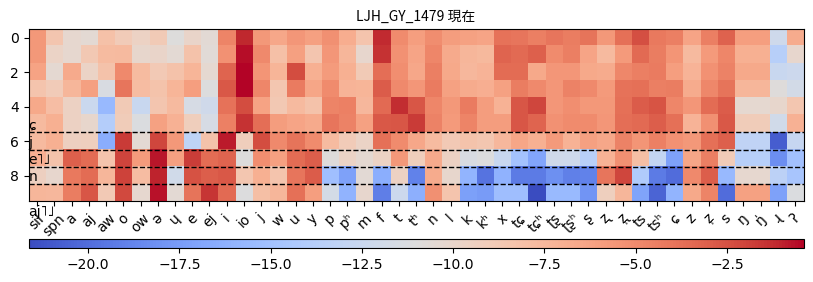

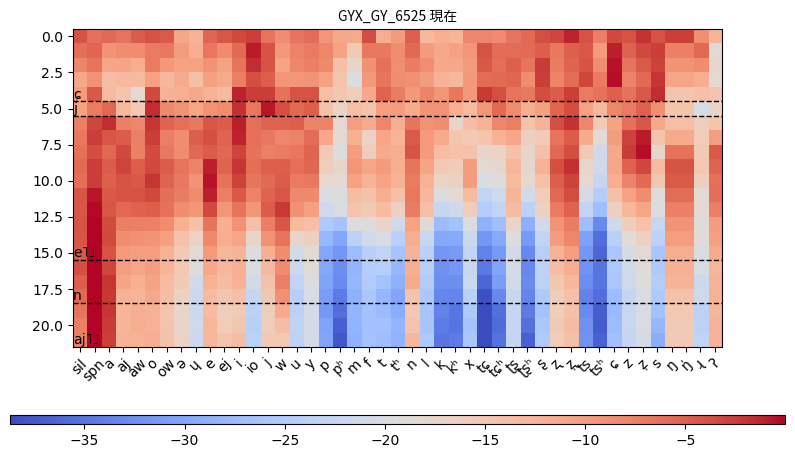

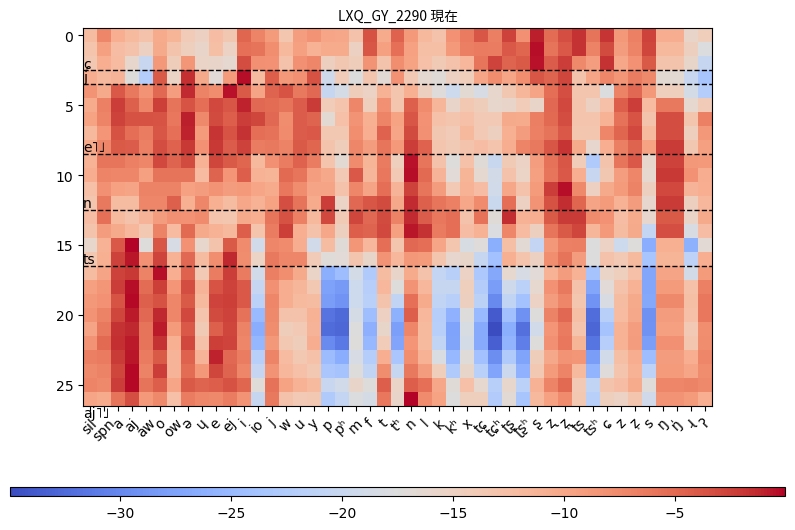

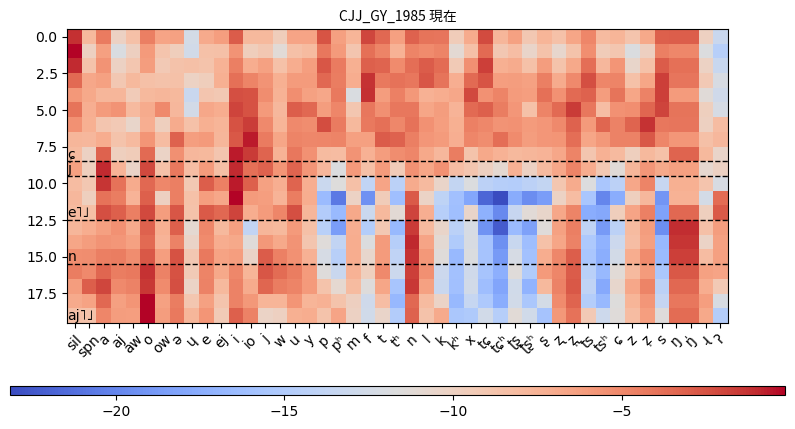

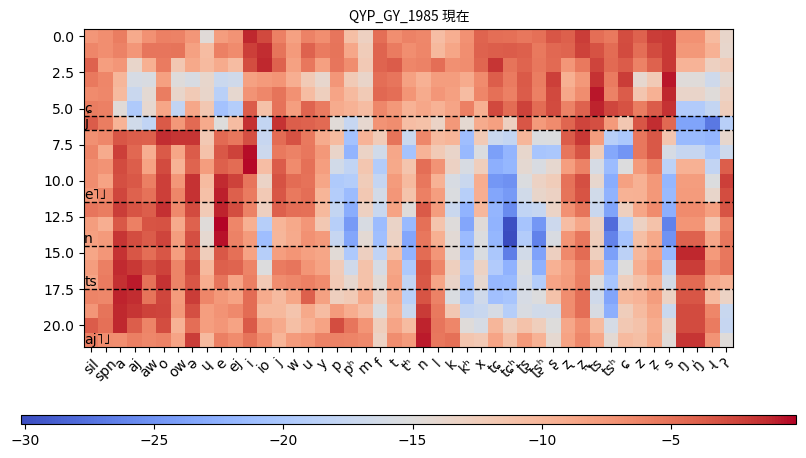

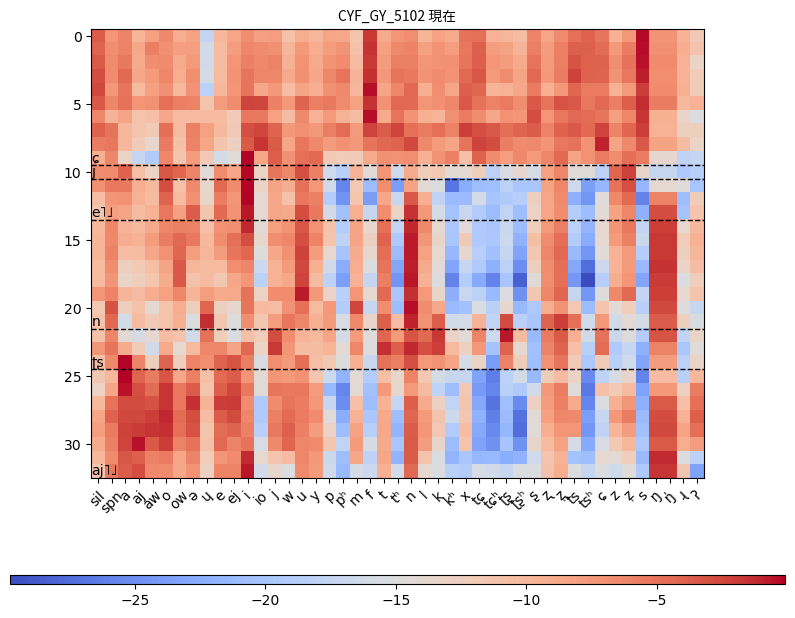

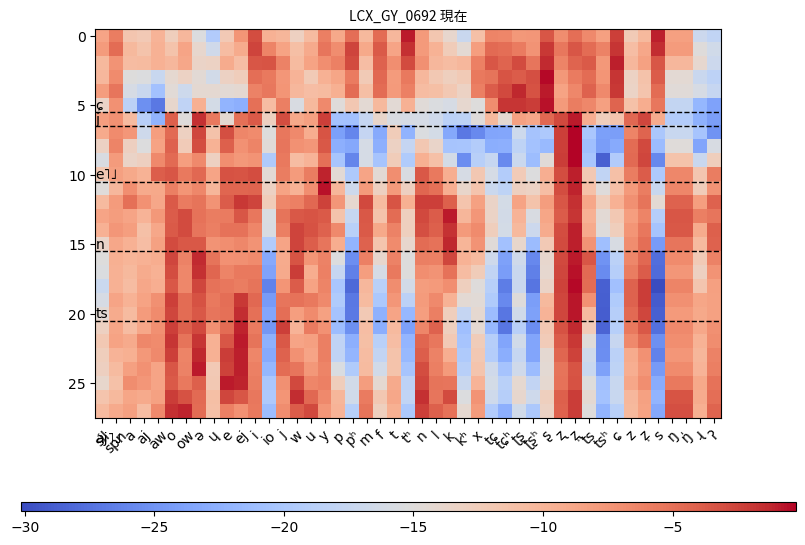

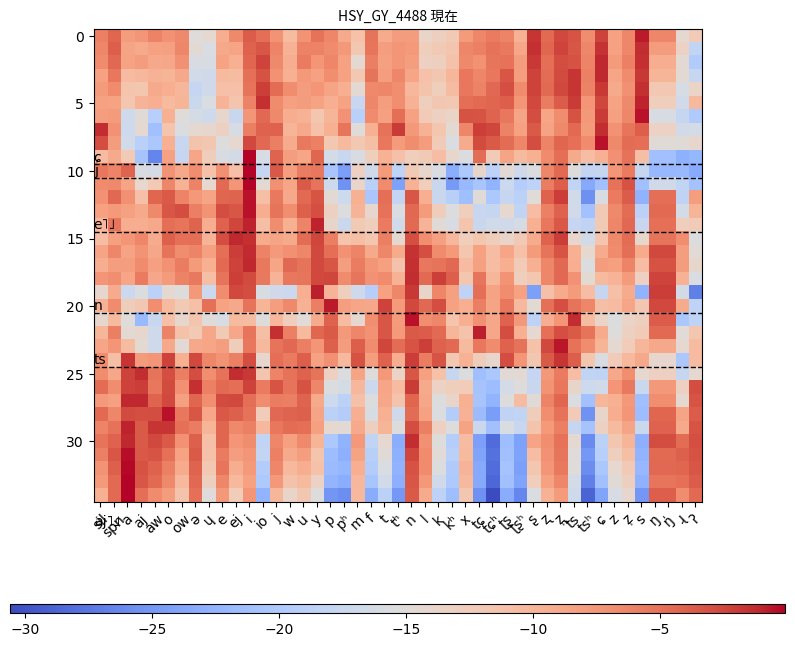

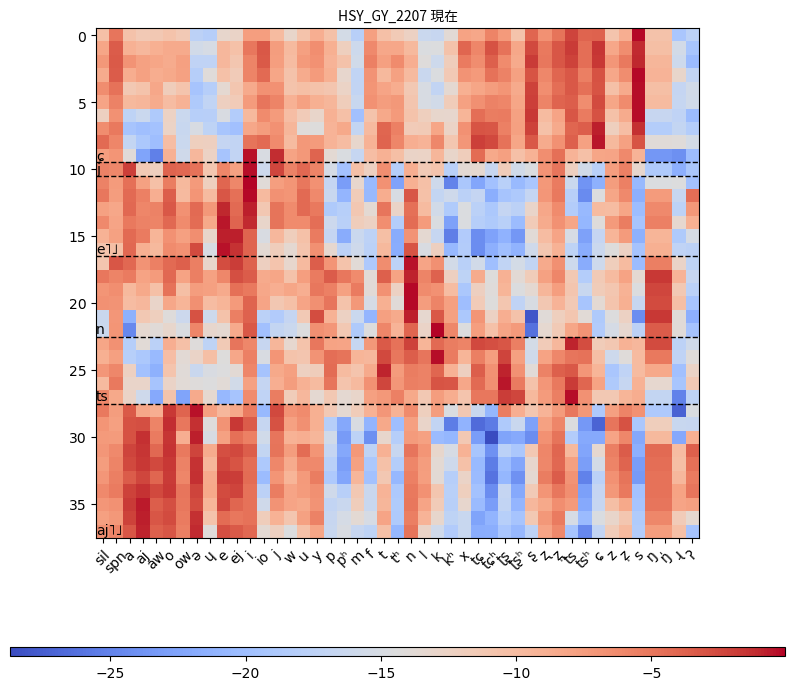

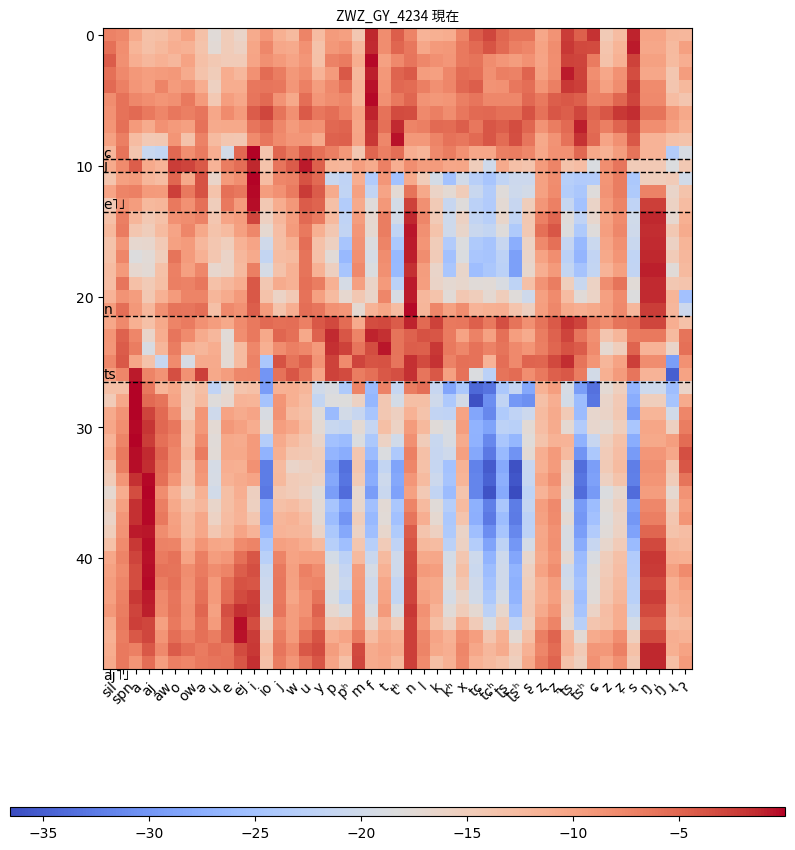

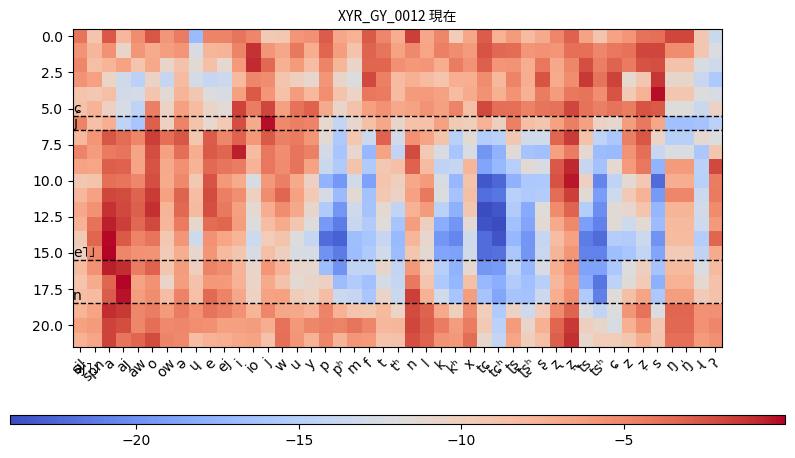

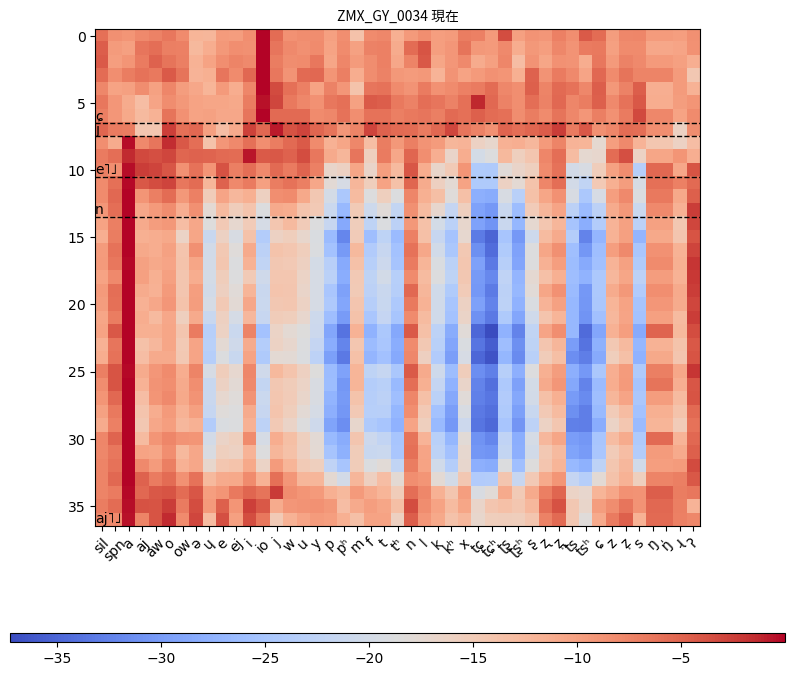

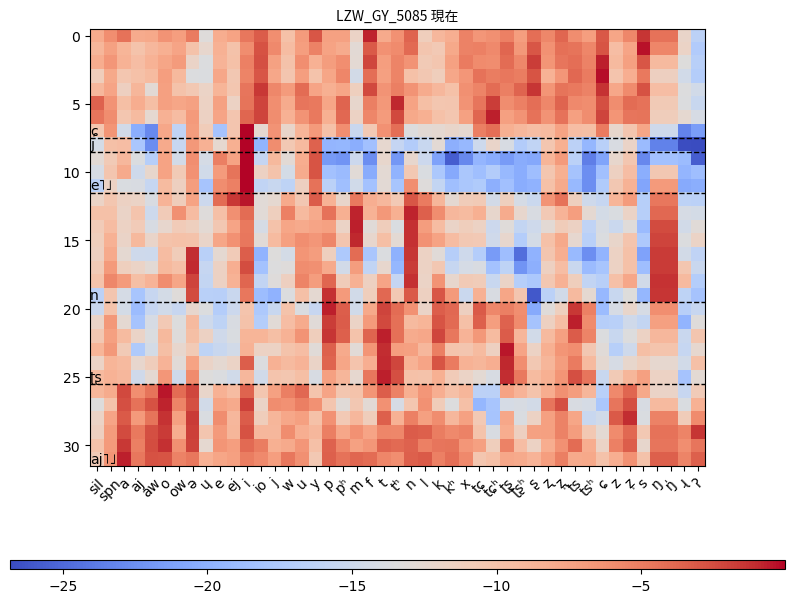

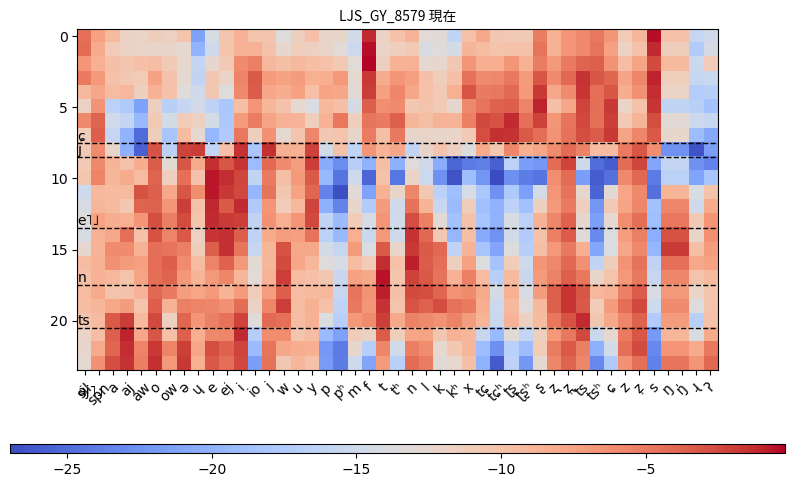

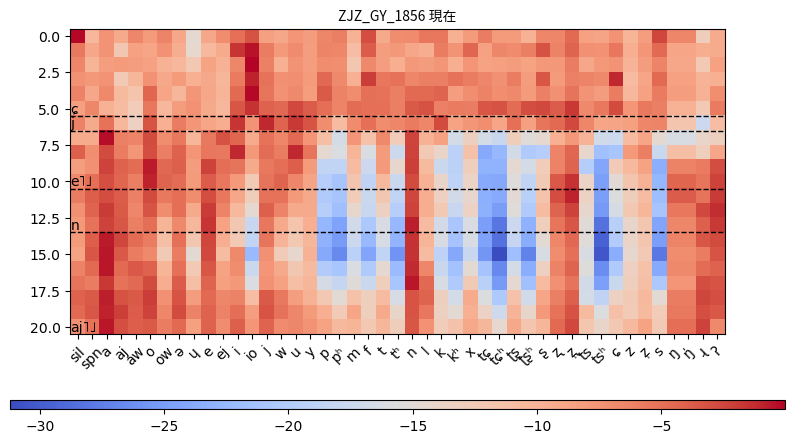

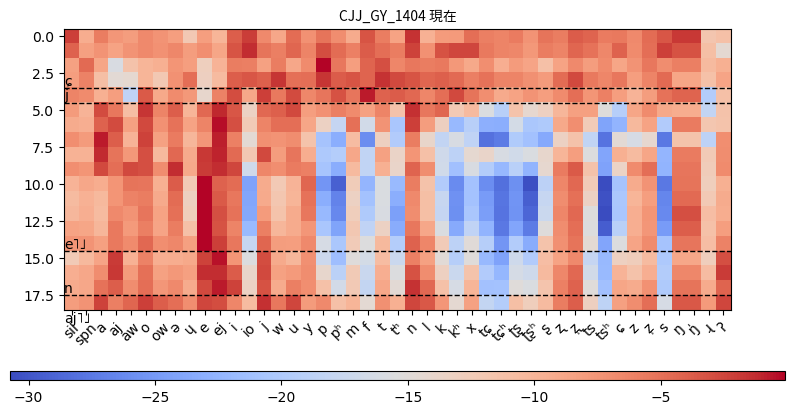

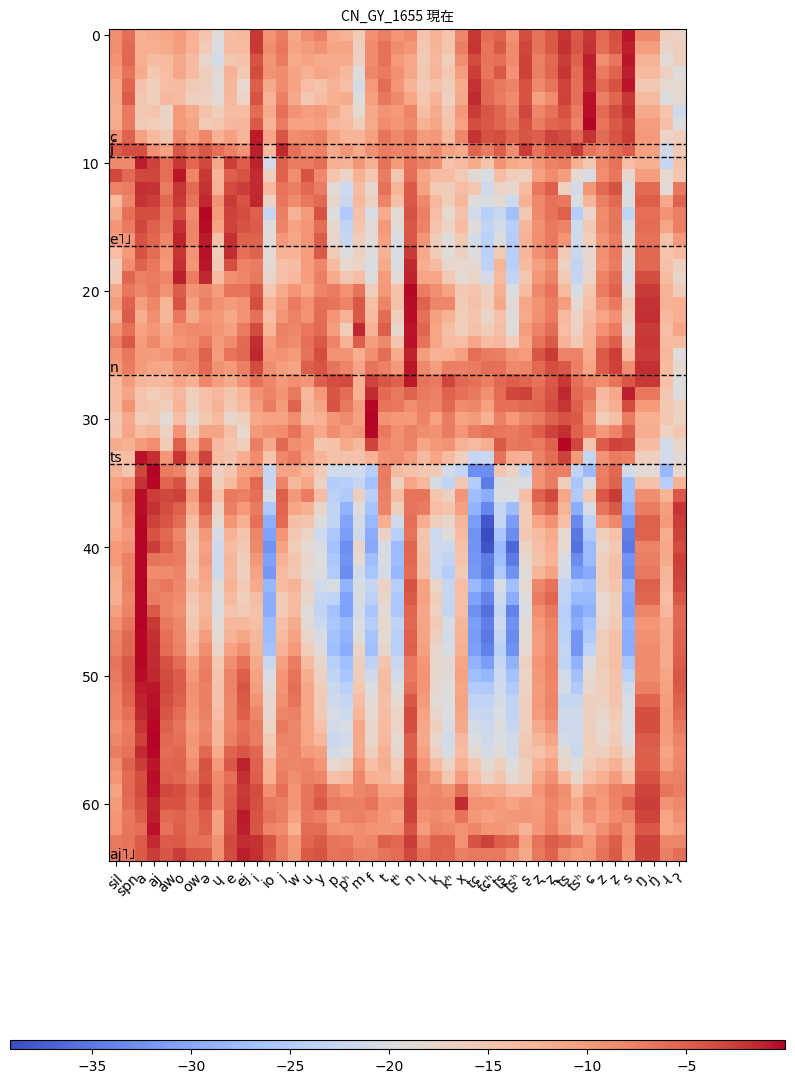

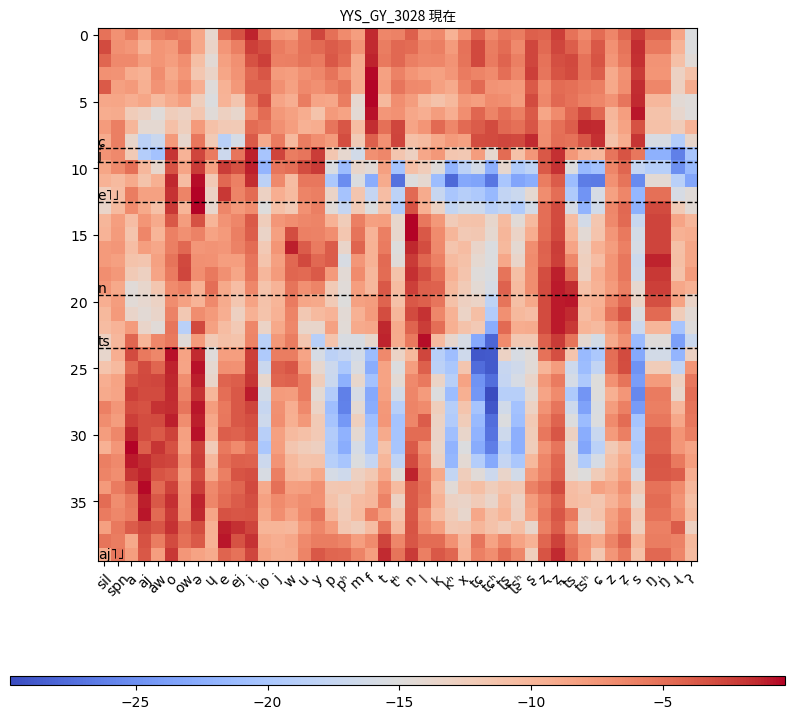

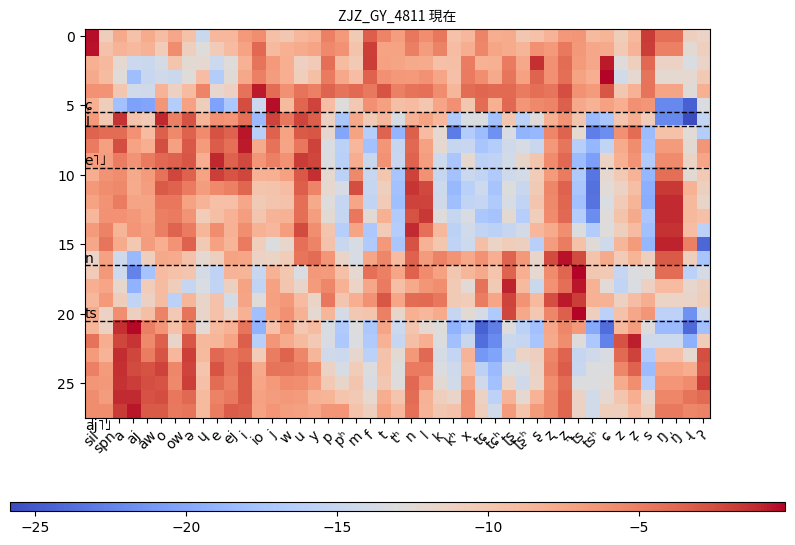

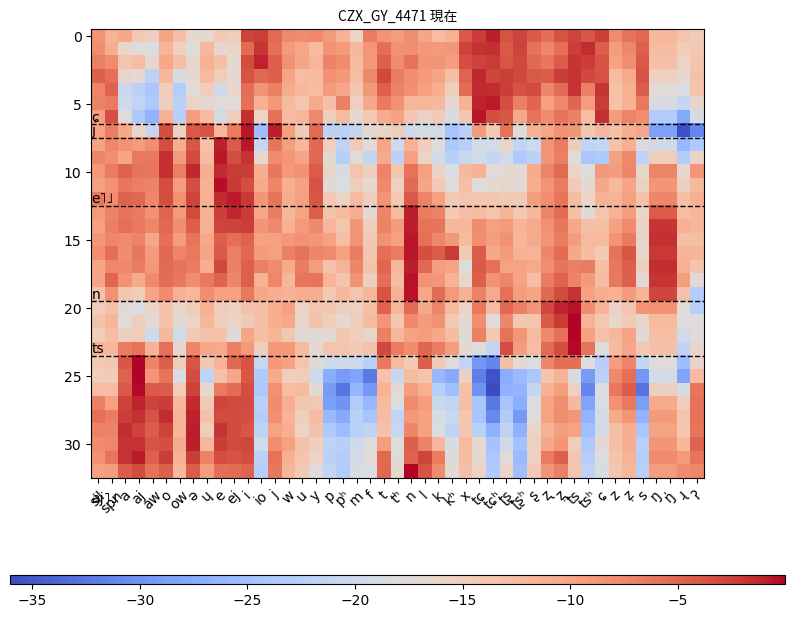

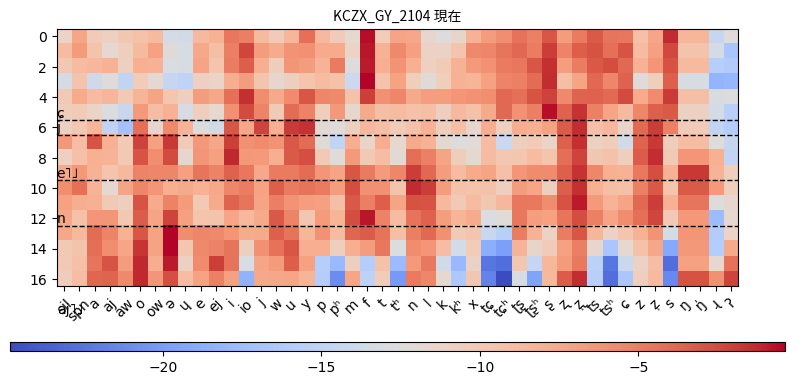

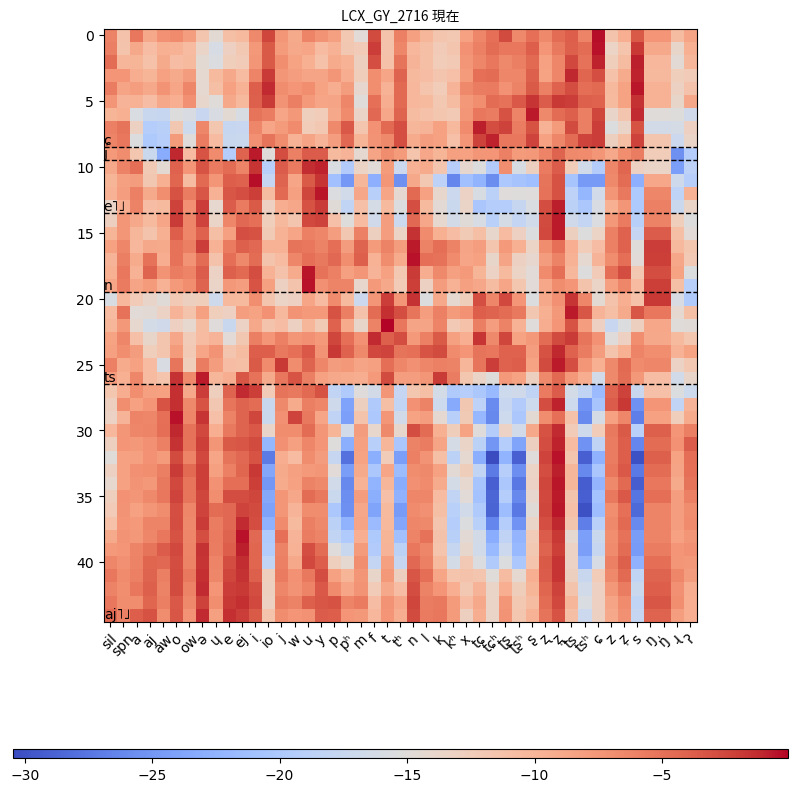

In [6]:
import matplotlib.pyplot as plt
plt.ioff()

fig_dir = Path("../data/figures/xianzai/")
fig_dir.mkdir(parents=True, exist_ok=True)

for speech_idx, speech_x in enumerate(tqdm(agent.speeches)):
    if speech_idx % 40 != 0:
        ## just sample a few cases
        continue
    utt_x = speech_x.utterances[0]
    word_x = utt_x.words[0]
    print(utt_x.utt_id, word_x)
    mfa_uttid = agent.wav2uttid[utt_x.utt_id]
    start_step = int((word_x.start-utt_x.start)/0.01)
    end_step = int((word_x.end-utt_x.start)/0.01)
    lgmmprob = agent.compute_gmm(mfa_uttid)

    pmat = lgmmprob[start_step:end_step, :]
    fig = plt.figure(figsize=(10, 10*(pmat.shape[0]/pmat.shape[1])+1))
    plt.imshow(pmat, 
                cmap="coolwarm")
    for pidx, phone_x in enumerate(word_x.iter_phones()):
        print(phone_x)
        p_start = int((phone_x.start-word_x.start)/0.01)
        p_end = int((phone_x.end-word_x.start)/0.01)
        plt.text(-0.5, p_end-0.5, phone_x.label, va="bottom")
        if pidx > 0:
            plt.axhline(p_start-0.5, color="black", 
                    linewidth=1, linestyle="dashed")

    xticks = range(0, len(agent.phone_table), 1)
    xticklabels = [agent.phone_table[y] for y in xticks]
    plt.xticks(xticks, xticklabels, rotation=45) 
    plt.colorbar(location="bottom", aspect=80)
    plt.title(f"{utt_x.utt_id} {word_x.label}", fontsize=20, font="Noto Sans CJK JP")
    fig.savefig(str(fig_dir/f"{utt_x.utt_id}_{word_x.label}.png"))
    